In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/swellEx")

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import os.path
import datetime as d
import swellEx_env
from swellEx_env import getRangeAtTime as getRange
from normalMode import Chinook

import loadSIO as sio

ImportError: No module named 'swellEx_env'

In [2]:
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
# dataFile = '/Users/edwardlrichards/Documents/data/SWellEx96/VLA_J132_0002'
x_year = str(1996)

# startTime = d.datetime.strptime(x_year+dataFile[-9:],'%YJ%j_%H%M')
tStart = 3300
tMF = 3450
deltaT = 500  # used in plots
fs = 1500
# print(sio.load_header(dataFile)['samplesPerChannel'])

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
# rangeTime = experimentStart + d.timedelta(0, tStart)

# figure output directory
figDir = '/Users/edwardlrichards/Documents/Classes/convexOptimization/figures'

In [3]:
sampleStart = tStart * fs
experiment = sio.load_selection(dataFile, sampleStart - 1,\
    sio.load_header(dataFile)['samplesPerChannel'] - sampleStart, [0,1])

t = np.arange(experiment['data'].shape[0]) / fs
record = pd.DataFrame(experiment['data'], index = t)


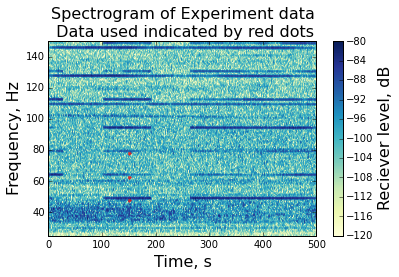

In [4]:
sampleLength = 2 ** 11

Pxx, freqs, bins, im = plt.specgram(record[0], NFFT = sampleLength,\
        pad_to = 2 * sampleLength, Fs = fs,\
        noverlap = sampleLength / 2, cmap=plt.cm.YlGnBu)

frequencies = [49, 64, 79, 94, 112, 130, 148,\
               166, 201, 235, 283, 338, 388]

tExperiment = tMF - tStart

for i, j in enumerate(frequencies):
    
    if i < 3:
        _ = plt.plot(tExperiment, j-1, 'r.', alpha = 0.75)
    
_ = plt.clim(-120, -80)
cbar = plt.colorbar()
cbar.set_label('Reciever level, dB', fontsize=16)
_ = plt.ylim(25, 150)
_ = plt.xlim(0, deltaT)
_ = plt.xlabel('Time, s', fontsize=16)
_ = plt.ylabel('Frequency, Hz', fontsize=16)
_ = plt.title('Spectrogram of Experiment data\n Data used indicated by red dots', fontsize=16)
plt.subplots_adjust(top=0.8)
_ = plt.savefig(os.path.join(figDir, 'spec'))

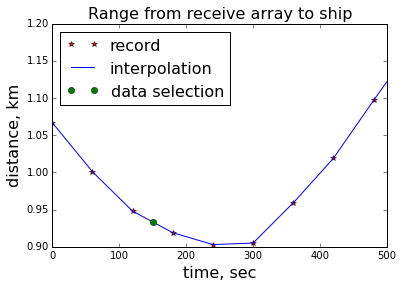

In [5]:
numMin = np.ceil(deltaT / 60) + 1
minutes = np.arange(numMin)
decT = np.r_[0:deltaT:200j]
sourceRange = np.array([getRange(experimentStart +\
        d.timedelta(0,i*60 + tStart)) for i in minutes])

interpRange = np.interp(decT, minutes * 60, sourceRange)
exRange = interpRange[np.argmin(np.abs(decT - (tMF - tStart)))]
_ = plt.plot(60 * minutes, sourceRange,'r*',label='record')
_ = plt.plot(decT, interpRange,label='interpolation')
_ = plt.plot(decT[np.argmin(np.abs(decT - (tMF - tStart)))],\
        exRange, 'go', label='data selection')
_ = plt.plot()
_ = plt.xlabel('time, sec', fontsize=16)
_ = plt.ylabel('distance, km', fontsize=16)
_ = plt.xlim(0, deltaT)
_ = plt.title('Range from receive array to ship ', fontsize=16)
_ = plt.legend(loc=2, fontsize=16)
_ = plt.savefig(os.path.join(figDir, 'sourceRange'))

In [6]:
zMax = 120
rMax = 2000  # m
rMin = 500
numR = 100
numZ = 50

sD = 54

# Solver Parameters
decimation = 10
fB_width = 300

#Look grid
zPlot = np.r_[1:220:200 * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R, Z = np.meshgrid(rPlot, zPlot)

enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)

nm_model = Chinook(49, enviornment)
nm_model.calculateModes_eig(fB_width, decimation)
syntheticData = nm_model.calculatePressure(sD,\
                    zPlot, rPlot)
TL = 20 * np.log10(np.abs(syntheticData) + np.spacing(1))

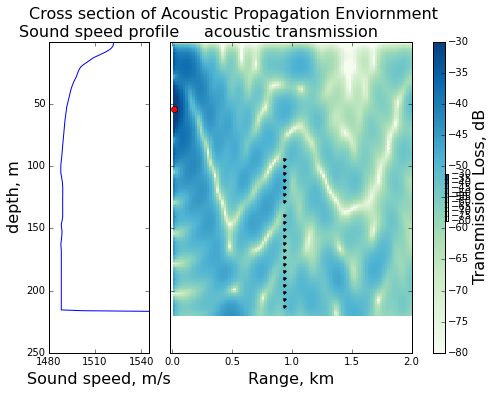

In [7]:
profile = enviornment.getProfile(0.)
zProfile = np.r_[0:250:400j]

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(100,100,bottom=0.18,left=0.18,right=0.88) 

ax1 = plt.subplot(gs[:,:25])

_ = ax1.plot(profile.getCatZ(zProfile), zProfile)
_ = ax1.set_xlim(1480, 1545)
_ = ax1.set_ylim(np.max(zProfile), 0)
ax1.set_xticks(np.r_[1480:1540:3j])
ax1.set_yticks([50, 100, 150, 200, 250])

ax1.set_xlabel('Sound speed, m/s', fontsize=16)
ax1.set_ylabel('depth, m', fontsize=16)
ax1.set_title('Sound speed profile', fontsize=16)


ax2 = plt.subplot(gs[:,30:90])
pcol = ax2.pcolormesh(R / 1e3, Z, np.array(TL.T),\
                      cmap=plt.cm.get_cmap('GnBu'))
ax2.plot(0.010,sD,'ro')
ax2.plot(exRange * np.ones(sensorPosition.shape),\
         sensorPosition.values, 'k.')

ax2.set_xlabel('Range, km', fontsize=16)
ax2.set_xlim(-.02, np.max(rPlot) / 1e3)
ax2.set_ylim(np.max(zProfile), 0)
ax2.set_yticklabels('')
ax2.set_title('acoustic transmission', fontsize=16)

ax3 = plt.subplot(gs[:,95:99])

cbar = fig.colorbar(pcol)
pcol.set_clim(-80, -30)

cbar = fig.colorbar(pcol,ax=ax2,cax=ax3)

cbar.set_label('Transmission Loss, dB', fontsize=16)
_ = plt.suptitle('Cross section of Acoustic Propagation Enviornment', fontsize=16)
_ = plt.savefig(os.path.join(figDir, 'acousticEnv'))